In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sn
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

import pandas as pd
import numpy as np
import os
import glob


### *functions*

In [20]:
def get_label_from_filename(filename): 
    if "Phantom" in filename: return "Phantom"
    elif "Ruko_F11_Pro" in filename: return "Ruko_F11_Pro"
    elif "Ruko_F11_base" in filename: return "Ruko_F11_base"
    elif "Mavic_Air_2_" in filename: return "Mavic_Air_2"
    elif "Mavic_Air_2S" in filename: return "Mavic_Air_2S"
    elif "DeerC" in filename: return "DeerC_DE2"
    elif "Mini_SE" in filename: return "Mini_SE"
    elif "Holystone_HS100" in filename: return "Holystone_HS100"
    elif "None" in filename: return "None"
    else: return "UNKNOWN_LABEL"



def load_iq(f, chunk_size, every_n_rows):
    # The chunking in this algo is so that we can read in large files (156M lines or more). 
    # In order to reduce compution time, we skip n number of rows. 
    result = pd.DataFrame()

    for chunk in pd.read_csv(f, chunksize=chunk_size):
        result = pd.concat([result, chunk.iloc[::every_n_rows, :]], ignore_index=True)

    # print("THE DF:\n", result)
    result = result[['i', 'q']].to_numpy()
    return result


# metric's functions 
def checkForFilename(base_name): 
    ext = ".txt"
    i = 1
    filename = f"{base_name}{ext}"
    while os.path.exists(filename):
        filename = f"{base_name}_{i}{ext}"
        i += 1
    return filename

def saveMetricsToFile(base_name, perc_accuracy): 
    filename = checkForFilename(base_name)
    with open(filename, "w") as f:
        f.write(f"Accuracy: {perc_accuracy:.2f}%\n\n")
        f.write("The important vars:\n")
        f.write(f"window_size: {window_size}\n")
        f.write(f"step: {step}\n")
        f.write(f"every n rows: {every_n_rows}\n")
        f.write(f"chunk size: {chunk_size}\n\n")
        f.write("Classification Report:\n")
        f.write(f"{cr}\n\n")
        f.write("Confusion Matrix:\n")
        f.write(f"{cm}\n")

### *variables*

In [21]:
# Path to your IQ files
data_dir = "./data/"
drone_csv_files = glob.glob(os.path.join(data_dir, "*.csv"))
print(drone_csv_files)

chunk_size = 10_000 # how many rows to hold in memory at a time
every_n_rows = 50

# Example: sample windows with 50% overlap
# window_size = 1024 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)
window_size = 1024 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)
window_size = 2048 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)
window_size = 4096 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)
window_size = 8192 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)
window_size = 16_384 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)
window_size = 32_768 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)

# step = 8192
# step = 4096
# step = 2048
step = 1024
# step = 512

skipSVC = False
skipRF = True

['./data/iqSamples_Ruko_F11_Pro.csv', './data/iqSamples_Phantom.csv', './data/iqSamples_Mini_SE.csv', './data/iqSamples_Mavic_Air_2_.csv', './data/iqSamples_Holystone_HS100.csv', './data/iqSamples_Ruko_F11_base.csv', './data/iqSamples_Mavic_Air_2S.csv', './data/iqSamples_None.csv', './data/iqSamples_DeerC_DE2.csv']


## Loading Dataset

### *Reading in files*

In [ ]:
X = []
y = []

segments = []
labels = []


# create an array of dataframes.
# each dataframe containing iq samples from one file
for file in drone_csv_files:
    print("File: ", file)
    label = get_label_from_filename(file)
    # print("Label: ", label)
    iq = load_iq(file, chunk_size, every_n_rows)  # shape (N, 2)
    # print("File:\n", iq)
    for i in range(0, len(iq)-window_size, step):
        window = iq[i:i+window_size].flatten()
        segments.append(window)
        labels.append(label)
    # print("Segments:\n", segments)
    # print("Labels:\n", labels)

X = np.array(segments)
y = np.array(labels)

File:  ./data/iqSamples_Ruko_F11_Pro.csv


### *Displaying things*

In [ ]:
print("Segments:")
print("Shape: ", X.shape)
print(X)
print("-------------------------------------------------------------------")
print("Labels:")
print("Shape: ", y.shape)
print(y)

Segments:
Shape:  (24434, 65536)
[[-3384. -5693.  6926. ...    31.   -31.    31.]
 [  -94.   126.  -474. ...  -506.  -379.   189.]
 [  -31.  -600.  -126. ...    31.  -221.    94.]
 ...
 [ -257.   137.  -137. ...   -85.    85.   240.]
 [  -34.   -17.     0. ...     0.   257.  -240.]
 [   17.   -17.   137. ...   154.  -154.  -343.]]
-------------------------------------------------------------------
Labels:
Shape:  (24434,)
['Ruko_F11_Pro' 'Ruko_F11_Pro' 'Ruko_F11_Pro' ... 'DeerC' 'DeerC' 'DeerC']


In [ ]:
# print("labels: ")
# print(np.unique(y))
# print()

for sample, label in zip(X, np.unique(y)): 
    print("X feature:\n", sample)
    print("IQ samples in X feature: ", int(sample.size / 2))
    print("y label: ", label)
    print('------------------------------------------------------')

X feature:
 [-3384. -5693.  6926. ...    31.   -31.    31.]
IQ samples in X feature:  32768
y label:  DeerC
------------------------------------------------------
X feature:
 [ -94.  126. -474. ... -506. -379.  189.]
IQ samples in X feature:  32768
y label:  Mavic_Air_2
------------------------------------------------------
X feature:
 [ -31. -600. -126. ...   31. -221.   94.]
IQ samples in X feature:  32768
y label:  Mavic_Air_2S
------------------------------------------------------
X feature:
 [316.   0. -94. ... -63.   0.  31.]
IQ samples in X feature:  32768
y label:  Mini_SE
------------------------------------------------------
X feature:
 [-379.  -94.  158. ...  569. -379. -632.]
IQ samples in X feature:  32768
y label:  None
------------------------------------------------------
X feature:
 [-253.   63. -158. ... -316. -411.    0.]
IQ samples in X feature:  32768
y label:  Phantom
------------------------------------------------------
X feature:
 [ 221.  284.  -31. ... -822.  

: 

## Scalar Vector Classifier 

### *Training, fitting & predicting*

In [ ]:
# Train/test split (e.g. 80/20)
if not skipSVC: 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Standardize features (zero mean, unit variance)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

In [ ]:
# Fit and predict
if not skipSVC: 
    SVCModel = SVC(kernel='rbf', C=10, gamma='scale', max_iter=160_000)  # tweak C/gamma as needed
    SVCModel.fit(X_train, y_train)
    y_pred = SVCModel.predict(X_test)


SystemExit: Skipping this cell because skipSVC is True

### *Metrics*

In [ ]:
if not skipSVC: 
    accuracy = accuracy_score(y_test, y_pred)
    perc_accuracy = accuracy * 100
    print(f"Accuracy: {perc_accuracy:.2f}%")
    print()
    print("The important vars: ")
    print("window_size: ", window_size)
    print("step: ", step)
    print("every n rows: ", every_n_rows)
    print("chunk size: ", chunk_size)
    print()

    cr = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print(cr)
    print(cm)

    saveMetricsToFile('svc_metrics', perc_accuracy)

               precision    recall  f1-score   support

        DeerC       0.47      0.41      0.44       299
  Mavic_Air_2       0.41      0.76      0.53       298
 Mavic_Air_2S       1.00      0.02      0.03       299
      Mini_SE       0.60      0.57      0.59       299
         None       0.80      1.00      0.89       299
      Phantom       0.50      0.47      0.49       299
 Ruko_F11_Pro       0.68      0.79      0.73       299
Ruko_F11_base       1.00      1.00      1.00       299
UNKNOWN_LABEL       0.00      0.00      0.00        24

     accuracy                           0.62      2415
    macro avg       0.61      0.56      0.52      2415
 weighted avg       0.67      0.62      0.58      2415

Accuracy: 62.15%

[[123   0   0  24   0  71  81   0   0]
 [  0 227   0   2  69   0   0   0   0]
 [  0 294   5   0   0   0   0   0   0]
 [ 26   0   0 170   6  73  24   0   0]
 [  0   0   0   0 299   0   0   0   0]
 [ 64   0   0  86   0 142   7   0   0]
 [ 50  13   0   0   0   0 236 

/Users/carlos_1/Documents/GitHub/iq-classification-classical-models/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/carlos_1/Documents/GitHub/iq-classification-classical-models/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/carlos_1/Documents/GitHub/iq-classification-classical-models/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no 

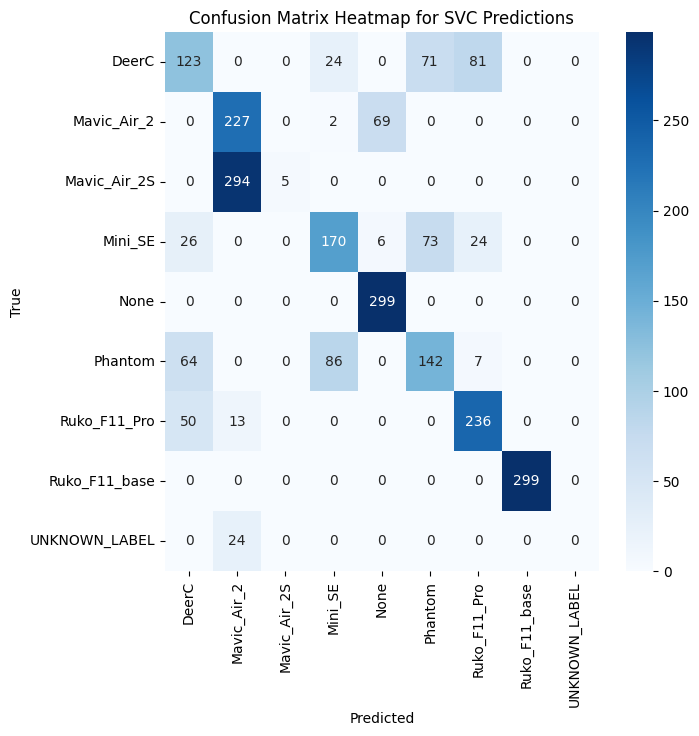

In [ ]:
# Create a heatmap of the confusion matrix
if not skipSVC: 
    plt.figure(figsize=(7, 7))
    sn.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(labels), yticklabels=np.unique(labels))

    # Labels and title
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap for SVC Predictions')

    plt.show()


## Random Forest Classifer 

### *Training, fitting & predicting*

I need to figure out how to use the random forest classifier for this. 

In [ ]:
# Labeling 
labelBinary = LabelBinarizer()

# Gender == 1 if Male
airlines["Gender"] = labelBinary.fit_transform(airlines["Gender"])
# Customer == 1 if Loyal
airlines["Customer"] = labelBinary.fit_transform(airlines["Customer"])
# TravelType == 1 if Personal
airlines["TravelType"] = labelBinary.fit_transform(airlines["TravelType"])
# Class == 1 if Business
airlines["Class"] = labelBinary.fit_transform(airlines["Class"])

In [ ]:
# Fit
if not skipRF: 
    rfModel = RandomForestClassifier()
    rfModel.fit(X, np.ravel(y))
    

### *Metrics*

In [ ]:
if not skipRF: 
    accuracy = accuracy_score(y_test, y_pred)
    perc_accuracy = accuracy * 100
    print(f"Accuracy: {perc_accuracy:.2f}%")
    print()
    print("The important vars: ")
    print("window_size: ", window_size)
    print("step: ", step)
    print("every n rows: ", every_n_rows)
    print("chunk size: ", chunk_size)
    print()

    cr = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print(cr)
    print(cm)

    saveMetricsToFile('svc_metrics', perc_accuracy)

               precision    recall  f1-score   support

        DeerC       0.47      0.41      0.44       299
  Mavic_Air_2       0.41      0.76      0.53       298
 Mavic_Air_2S       1.00      0.02      0.03       299
      Mini_SE       0.60      0.57      0.59       299
         None       0.80      1.00      0.89       299
      Phantom       0.50      0.47      0.49       299
 Ruko_F11_Pro       0.68      0.79      0.73       299
Ruko_F11_base       1.00      1.00      1.00       299
UNKNOWN_LABEL       0.00      0.00      0.00        24

     accuracy                           0.62      2415
    macro avg       0.61      0.56      0.52      2415
 weighted avg       0.67      0.62      0.58      2415

Accuracy: 62.15%

[[123   0   0  24   0  71  81   0   0]
 [  0 227   0   2  69   0   0   0   0]
 [  0 294   5   0   0   0   0   0   0]
 [ 26   0   0 170   6  73  24   0   0]
 [  0   0   0   0 299   0   0   0   0]
 [ 64   0   0  86   0 142   7   0   0]
 [ 50  13   0   0   0   0 236 

/Users/carlos_1/Documents/GitHub/iq-classification-classical-models/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/carlos_1/Documents/GitHub/iq-classification-classical-models/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/carlos_1/Documents/GitHub/iq-classification-classical-models/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no 

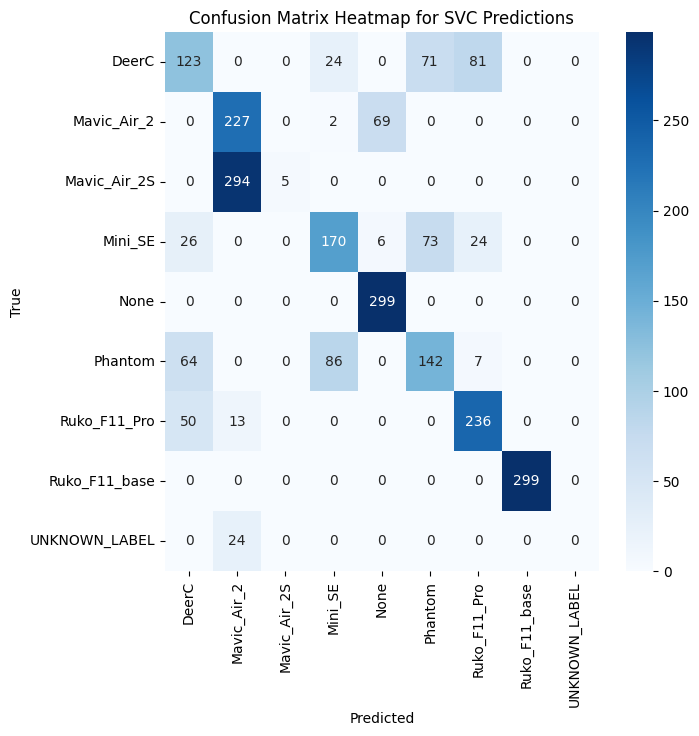

In [ ]:
# Create a heatmap of the confusion matrix
if not skipRF: 
    plt.figure(figsize=(7, 7))
    sn.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(labels), yticklabels=np.unique(labels))

    # Labels and title
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap for SVC Predictions')

    plt.show()
